<a href="https://colab.research.google.com/github/SoheliPaul/Deep-Learning/blob/main/2348561_DL_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [2]:
df = pd.read_csv('/content/Gold Price (2013-2023).csv')

In [3]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [6]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(2583, 5)

In [9]:
df.info

<bound method DataFrame.info of            Date   Price    Open     High      Low
0    2013-01-02  1689.9  1675.8  1695.00  1672.10
1    2013-01-03  1675.6  1688.0  1689.30  1664.30
2    2013-01-04  1649.9  1664.4  1664.40  1630.00
3    2013-01-07  1647.2  1657.3  1663.80  1645.30
4    2013-01-08  1663.2  1651.5  1662.60  1648.80
...         ...     ...     ...      ...      ...
2578 2022-12-26  1809.7  1805.8  1811.95  1805.55
2579 2022-12-27  1823.1  1808.2  1841.90  1808.00
2580 2022-12-28  1815.8  1822.4  1822.80  1804.20
2581 2022-12-29  1826.0  1812.3  1827.30  1811.20
2582 2022-12-30  1826.2  1821.8  1832.40  1819.80

[2583 rows x 5 columns]>

In [10]:
df.describe

<bound method NDFrame.describe of            Date   Price    Open     High      Low
0    2013-01-02  1689.9  1675.8  1695.00  1672.10
1    2013-01-03  1675.6  1688.0  1689.30  1664.30
2    2013-01-04  1649.9  1664.4  1664.40  1630.00
3    2013-01-07  1647.2  1657.3  1663.80  1645.30
4    2013-01-08  1663.2  1651.5  1662.60  1648.80
...         ...     ...     ...      ...      ...
2578 2022-12-26  1809.7  1805.8  1811.95  1805.55
2579 2022-12-27  1823.1  1808.2  1841.90  1808.00
2580 2022-12-28  1815.8  1822.4  1822.80  1804.20
2581 2022-12-29  1826.0  1812.3  1827.30  1811.20
2582 2022-12-30  1826.2  1821.8  1832.40  1819.80

[2583 rows x 5 columns]>

In [11]:
df.isnull().sum().sum()

0

In [12]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [13]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

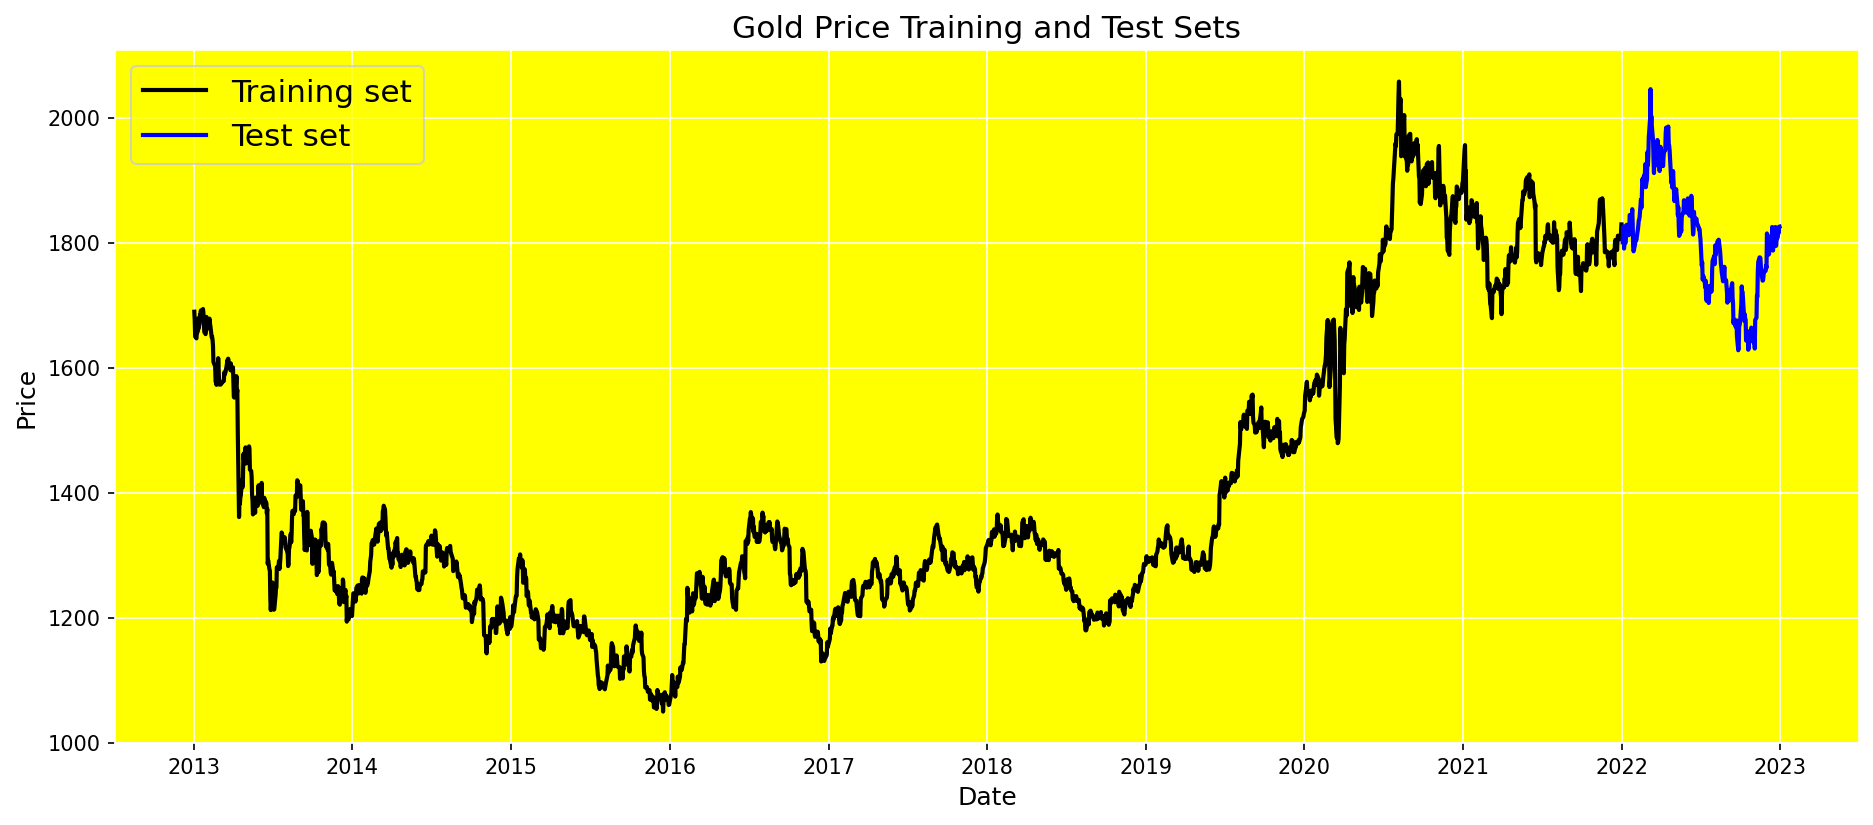

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [15]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [16]:
window_size = 60

In [17]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [18]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [20]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [21]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [23]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


In [24]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [25]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)
history_dict=history.history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

Text(0.5, 0, 'Epochs')

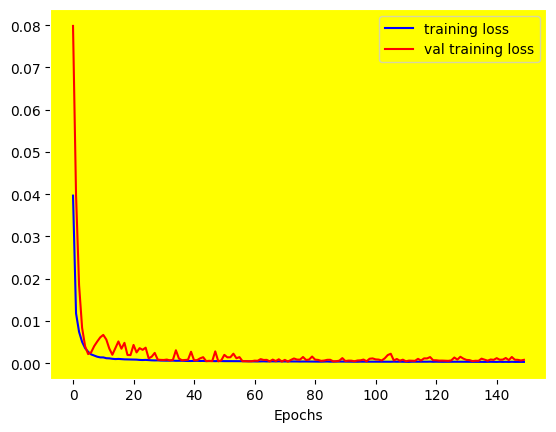

In [26]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [28]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 [==============================] - 2s 69ms/step


In [29]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [30]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0007937593036331236
Test MAPE: 0.030333764270912583
Test Accuracy: 0.9696662357290874


In [31]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

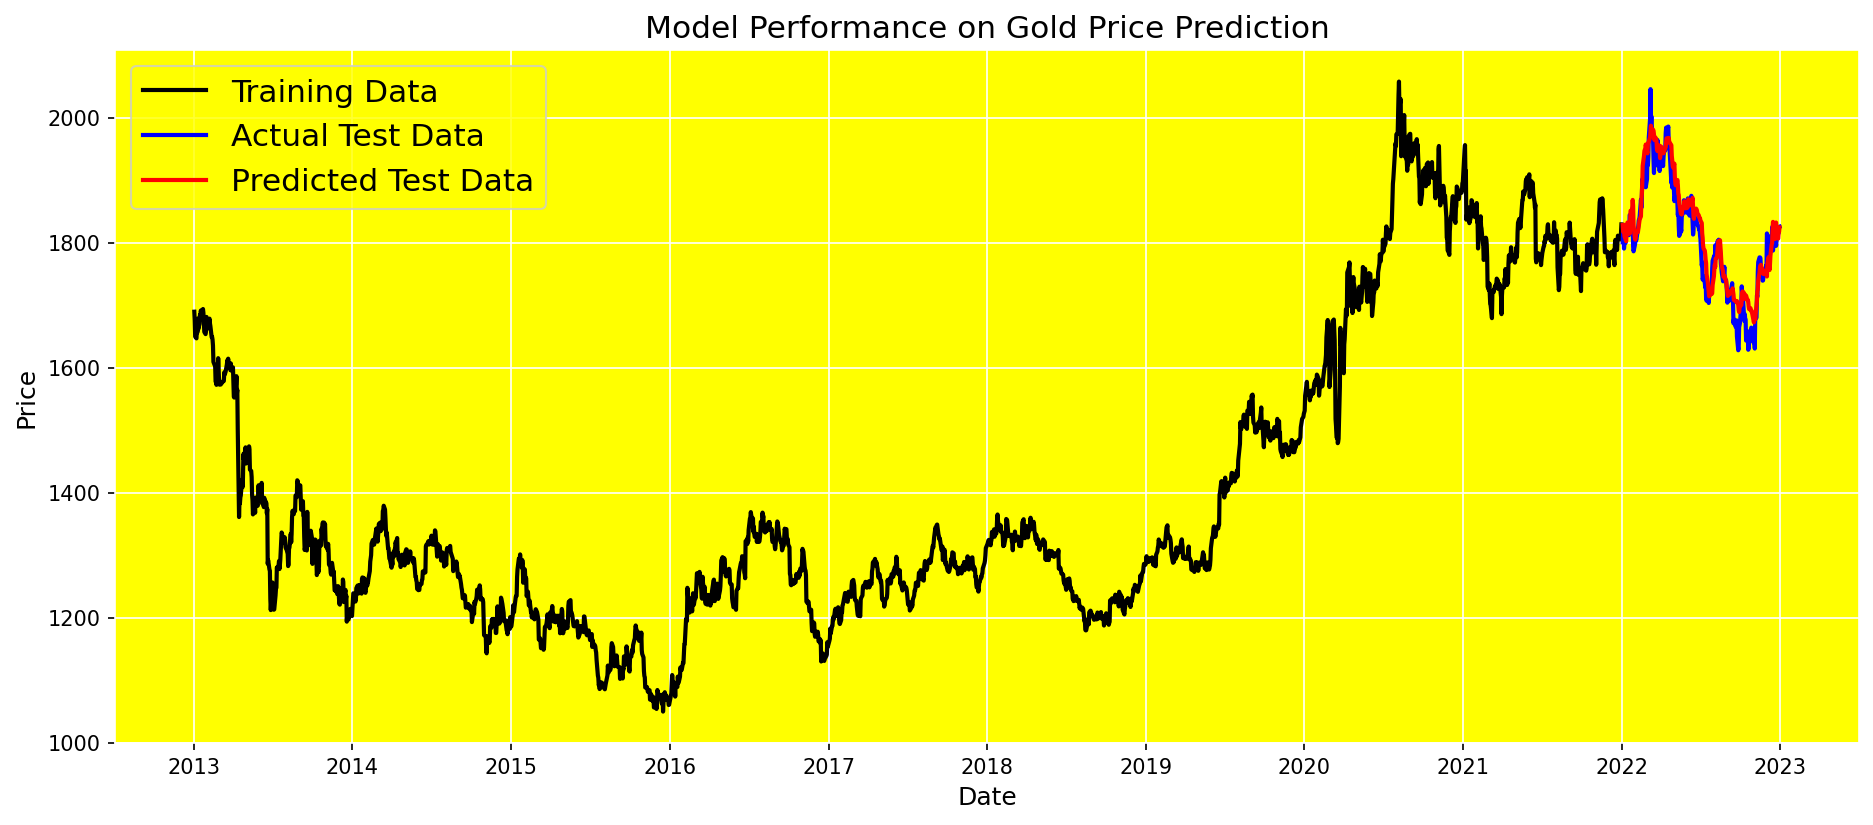

In [32]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()